In [2]:
import diffrax as dx
import jax.numpy as jnp
from jax import Array
import numpy as np
import matplotlib.pyplot as plt
import optax
from dynamiqs import basis, sesolve, dag, modulated
from dynamiqs import destroy

from optamiqs import GRAPEOptions, grape, hamiltonian_time_updater, coherent_infidelity, forbidden_states, all_cardinal_states, generate_file_path

In [16]:
optimizer = optax.adam(learning_rate=0.0001, b1=0.999, b2=0.999)
time = 20.0 # 30
control_dt = 2.0
ramp_nts = 4
dim = 5
Kerr = -2.0 * jnp.pi * 0.100
ntimes = int(time // control_dt) + 1
tsave = jnp.linspace(0, time, ntimes)

In [17]:
cos_ramp = (1 - jnp.cos(jnp.linspace(0.0, jnp.pi, ramp_nts))) / 2
envelope = jnp.concatenate(
    (cos_ramp, jnp.ones(ntimes - 2 * ramp_nts), jnp.flip(cos_ramp))
)

In [18]:
options = GRAPEOptions(
    save_states=True,
    progress_meter=None,
    target_fidelity=0.995,
    epochs=4000,
)

In [19]:
a = destroy(dim)
H0 = -0.5 * Kerr * dag(a) @ dag(a) @ a @ a
H1s = [a + dag(a), 1j * (a - dag(a))]
H1_labels = ['I', 'Q']

In [20]:
initial_states = [basis(dim, 0), basis(dim, 1)]
final_states = [basis(dim, 1), basis(dim, 0)]
_forbidden_states = [basis(dim, idx) for idx in range(2, dim)]

In [21]:
forbidden_states_list = len(initial_states) * [_forbidden_states, ]
init_drive_params = {
        "dp": -0.001 * jnp.ones((len(H1s), ntimes)),
        "t": tsave[-1],
    }

In [22]:
def _drive_spline(
    drive_params: Array, envelope: Array, ts: Array
) -> dx.CubicInterpolation:
    # note swap of axes so that time axis is first
    drive_w_envelope = jnp.einsum('t,...t->t...', envelope, drive_params)
    drive_coeffs = dx.backward_hermite_coefficients(ts, drive_w_envelope)
    return dx.CubicInterpolation(ts, drive_coeffs)

In [23]:
def H_func(drive_params_dict: dict) -> Array:
    drive_params = drive_params_dict["dp"]
    H = H0
    for H1, drive_param in zip(H1s, drive_params):
        drive_spline = _drive_spline(drive_param, envelope, tsave)
        H += modulated(drive_spline.evaluate, H1)
    return H

In [24]:
pulse_optimizer = hamiltonian_time_updater(H_func, lambda _H, _dp: (_H(_dp), tsave))

In [37]:
costs = [
    coherent_infidelity(target_states=final_states, cost_multiplier=1.0),
    forbidden_states(forbidden_states=forbidden_states_list, cost_multiplier=0.0)
]

In [39]:
filename = generate_file_path('h5py', 'Kerr_oscillator', 'out')
opt_params = grape(
    pulse_optimizer,
    initial_states=initial_states,
    costs=costs,
    params_to_optimize=init_drive_params,
    filepath=filename,
    optimizer=optimizer,
    options=options,
)

saving results to Kerr_oscillator_v16.h5py
epoch: 0, fids: [0.00019819], elapsed_time: 0.001 s
epoch: 1, fids: [0.00023913], elapsed_time: 0.001 s
epoch: 2, fids: [0.00028545], elapsed_time: 0.001 s
epoch: 3, fids: [0.00033486], elapsed_time: 0.001 s
epoch: 4, fids: [0.00038803], elapsed_time: 0.001 s
epoch: 5, fids: [0.00044525], elapsed_time: 0.001 s
epoch: 6, fids: [0.0005061], elapsed_time: 0.001 s
epoch: 7, fids: [0.00057095], elapsed_time: 0.001 s
epoch: 8, fids: [0.0006395], elapsed_time: 0.001 s
epoch: 9, fids: [0.00071096], elapsed_time: 0.001 s
epoch: 10, fids: [0.00078619], elapsed_time: 0.001 s
epoch: 11, fids: [0.00086588], elapsed_time: 0.001 s
epoch: 12, fids: [0.00094807], elapsed_time: 0.001 s
epoch: 13, fids: [0.00103432], elapsed_time: 0.001 s
epoch: 14, fids: [0.0011245], elapsed_time: 0.001 s
epoch: 15, fids: [0.00121778], elapsed_time: 0.001 s
epoch: 16, fids: [0.0013147], elapsed_time: 0.001 s
epoch: 17, fids: [0.00141501], elapsed_time: 0.001 s
epoch: 18, fids: 

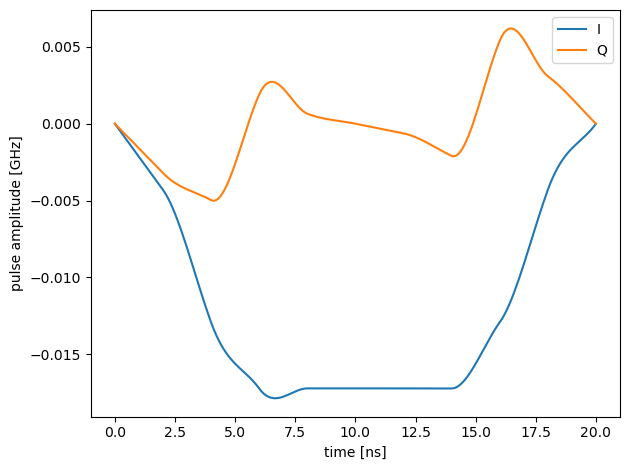

/Users/danielweiss/anaconda3/envs/optamiqs_dynamiqs_local_fork/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


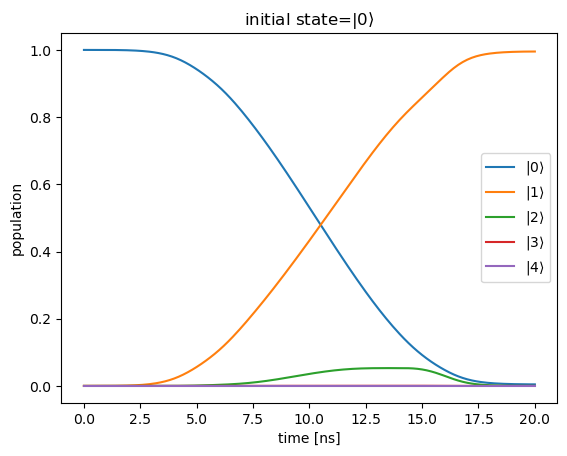

In [40]:
finer_times = jnp.linspace(0.0, tsave[-1], 201)
drive_spline = _drive_spline(opt_params["dp"], envelope, tsave)
drive_amps = jnp.asarray(
    [drive_spline.evaluate(t) for t in finer_times]
).swapaxes(0, 1)
fig, ax = plt.subplots()
for drive_idx in range(len(H1s)):
    plt.plot(
        finer_times,
        drive_amps[drive_idx] / (2.0 * np.pi),
        label=H1_labels[drive_idx],
    )
ax.set_xlabel('time [ns]')
ax.set_ylabel('pulse amplitude [GHz]')
ax.legend()
plt.tight_layout()
plt.show()

H = H_func(opt_params)
plot_result = sesolve(
    H,
    initial_states,
    finer_times,
    exp_ops=[basis(dim, idx) @ dag(basis(dim, idx))
             for idx in range(dim)],
    options=options,
)
exp_labels = [f'$|{idx}$' + r'$\rangle$' for idx in range(dim)]

# for brevity only plot one initial state
state_idx_to_plot = 0
fig, ax = plt.subplots()
expects = plot_result.expects[state_idx_to_plot]
for e_result, label in zip(expects, exp_labels):
    plt.plot(finer_times, e_result, label=label)
ax.legend()
ax.set_xlabel('time [ns]')
ax.set_ylabel('population')
ax.set_title(f'initial state={exp_labels[state_idx_to_plot]}')
plt.show()